In this assignment, we are analyzing how to simulate the continuous-time markov chains (CTMC).
We first give a few definitions to start with the problems.
We are given a weighted directed graph $\mathcal{G}=(\mathcal{V},\mathcal{E}, W) $ and one or more particles moving in the graph. Each particle will move to a node to one of his neibors with a probability proportional to the weight of the link between the two. In th case of the continous-time Markov Chains.
The Markov Chain $X(t)$ has a finite state space $\mathcal{X}$ which is our set of nodes $\mathcal{V}$. \
In the countinous case, the time a jump is performed is regulated by a Poisson process with rate $r$. We will call it "Poisson clock" and we will simulate its ticks. We will use a Poisson clock because the time between two "ticks" is an independent random variable with a Poisson distribution.

So we simulate the time between two consecutive ticks, $t_{next}$. It is computed as follows
$$ t_{next} = - \frac{\ln(u)}{r}$$
where $u$ is a random variable with uniform distribution, $u \in \mathcal{U}(0,1)$.



# Problem 1

In Problem 1, we analyze the trajectory of a *single particle* in the graph $\mathcal{G}$ defined below.

## Graph definition

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import HTML

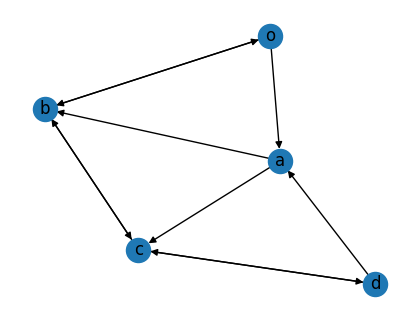

In [2]:
# draw graph
G = nx.DiGraph()
G.add_node('o')
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')
G.add_edges_from([('o', 'b'), ('o','a'), ('a','b'), ('a','c'), ('c','b'), ('c','d'), 
                  ('d','a'), ('d','c'), ('b', 'o'), ('b', 'c')])
pos = nx.spring_layout(G)
plt.figure(figsize=(4,3), dpi = 100)
nx.draw(G,pos, with_labels=True)

We now define some useful matrices and vectors to perform the simulations:
*   $\Lambda$ is a matrix given and it is the transition rate matrix; 
*   $\omega$ is the vector containg the rates for the Poisson clocks associated with each node, obtained from the expression $\omega_i= \sum_j \Lambda_{ij}$;
* When we will use one global Poisson clock with rate $\omega^* = \max_i(\omega_i)$, we will refer to the matrix $Q$. It contains the conditional probabilities of jumping from a node i to a neighbor node j or stay in node i when the global poisson clock at ticks: $Q_{ii} = 1 - \sum_{i \neq j} Q_{ij}$.
* Instead if we want to use a single Poisson clock for every node i with rate $\omega_i$, we will use the matrix $P$. It contains the conditional probabilities of jumping from a node i to a node j when the poisson clock at node i ticks:  $P_{ij} = \frac{\Lambda_{ij}}{\omega_i}$.
* The cumulative sums matrices $P_{cum}$ aand $Q_{cum}$ will be used in the following simulations. 
* The invariant probability vector $\overline{\pi}$, the i-th element contains the probability to end up in the i-th node.  


To perform the simulations in this exercise, we will use the approach involving the use of a Poisson clock with rate $\omega_i$ for every node i in our state space, $\forall i \in \mathcal{X}$.




In [3]:
lambda_matrix = np.array([
          [0,   2/5, 1/5, 0,   0],
          [0,   0,   3/4, 1/4, 0],
          [1/2, 0,   0,   1/2, 0],
          [0,   0,   1/3, 0,   2/3],
          [0,   1/3, 0,   1/3, 0]])

w = np.sum(lambda_matrix, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ lambda_matrix
P_cum = np.cumsum(P, axis=1)

n_nodes = len(G.nodes)

w_star = np.max(w)
Q = lambda_matrix/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
Q_cum = np.cumsum(Q, axis=1)

In [4]:
print("Number of nodes: ", n_nodes)
print("\Vector w:\n", w)
print("\nMatrix D:\n", D)
print("\nMatrix P:\n", P)
print("\nMatrix P_cum:\n", P_cum)
print("\nMatrix Q:\n", Q)
print("\nMatrix Q_cum:\n", Q_cum)

Number of nodes:  5
\Vector w:
 [0.6        1.         1.         1.         0.66666667]

Matrix D:
 [[0.6        0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.66666667]]

Matrix P:
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.5        0.         0.5        0.        ]]

Matrix P_cum:
 [[0.         0.66666667 1.         1.         1.        ]
 [0.         0.         0.75       1.         1.        ]
 [0.5        0.5        0.5        1.         1.        ]
 [0.         0.         0.33333333 0.33333333 1.        ]
 [0.         0.5        0.5        1.         1.        ]

In [5]:
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

pi_bar= [0.18518519 0.14814815 0.22222222 0.22222222 0.22222222]


## a. What is, according to the simulations, the average time it takes a particle that starts in node a to leave the node and then return to it?

In [ ]:
n_steps = 500
n_simulations = 10000
t_next = -np.log(np.random.rand())/w[1] #Poissn clock of node 'a'

array_return_time = np.zeros(n_simulations)

for j in range(0, n_simulations): # iterate over simulations
  end = False
  pos = np.zeros(n_steps, dtype=int)
  pos[0] = 1 # node 1 -> 'a'
  transition_times = np.zeros(n_steps)
  for i in range(1,n_steps): #iterate over number of steps
    if end==False:
      # the particle move from pos[i-1] to pos[i]
      pos[i] = np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0]
      transition_times[i] = transition_times[i-1] + t_next
      t_next = -np.log(np.random.rand())/w[pos[i]]
      if i != 1 and pos[i] == 1: #the particle is in node 'a' after exiting from it
        end = True
    else: 
      break

  array_return_time[j] = transition_times[i-1]
  
avg_return_time = np.mean(array_return_time)
print("Average return time: {} s".format(avg_return_time))

Average return time: 6.703006937816821 s


## b. How does the result in a) compare to the theoretical return-time $\mathbb{E}_a[T_a^+]$ ?  (Include a description of how this is computed.)

To compute the return-time we can apply the following formula: $\mathbb{E}_i[T_i^+] = \frac{1}{\omega_i \overline{\pi}_i}$, where $\overline{\pi}$ is the invariant probability vector.

In our case we can set $S=\{a\}$ and we obtain $\mathbb{E}_a[T_a^+] = \frac{1}{\omega_a \overline{\pi}_a}$

In [ ]:
values,vectors = np.linalg.eig(Q.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
#print("pi_bar=", pi_bar)

exp_return_time = 1 / (pi_bar*w)
# node a is at index 1, so we print the element 1 of the vector
print("Expected return time: {} s ".format(exp_return_time[1]))

Expected return time: 6.750000000000007 s 


## c. What is, according to the simulations, the average time it takes to move from node o to node d?

In [ ]:
n_steps = 500
n_simulations = 10000
t_next = -np.log(np.random.rand())/w[0] #Poissn clock of node 'o'


array_return_time = np.zeros(n_simulations)

for j in range(0, n_simulations): # iterate over simulations
  end = False
  pos = np.zeros(n_steps, dtype=int)
  pos[0] = 0 # node 0 -> 'o'
  transition_times = np.zeros(n_steps)
  for i in range(1,n_steps): #iterate over number of steps
    if end==False:
      # the particle move from pos[i-1] to pos[i]
      pos[i] = np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0]
      transition_times[i] = transition_times[i-1] + t_next
      t_next = -np.log(np.random.rand())/w[pos[i]]
      if pos[i] == 4:  #the particle is in 'd' after exiting from 'o'
        end = True
    else: 
      break

  array_return_time[j] = transition_times[i-1]
  
avg_return_time = np.mean(array_return_time)
print("Average return time: {} s".format(avg_return_time))

Average return time: 8.689513530115063 s


## d. How does the result in c) compare to the theoretical hitting-time $\mathbb{E}_o[T_d]$?  (Describe also how this is computed.)

The expected hitting times  $\overline{\tau}_i^S= (\mathbb{E}_i[T_S])_{i \in R}$ for the set $S={4}$ and for all nodes $i \in R = \mathcal V \setminus S$ can be computed by solving the system of equations
$$
\overline{\tau}_i^S = \frac{1}{\omega_i} + \hat{P}\overline{\tau}_j^S,
$$ 
where $\hat{P}$ is obtained from $P$  by removing the rows and columns corresponding to the nodes in the set $S$.
So we can compute the expected hitting times solving the following linear system:
$$
\overline{\tau}_i^S = (I - \hat{P})^{-1} \frac{1}{\omega_i}
$$

In [6]:
S = [4] # node d
R = [node for node in range(0,n_nodes) if node not in S]
len_R = n_nodes - len(S)
hatP = P[np.ix_(R, R )]
xhat = np.linalg.solve((np.identity(len_R)-hatP),np.ones(len_R)/w[R])
hitting_s = np.zeros(n_nodes)
hitting_s[R] = xhat
# node a is at index 0, so we print the element 0 of the vector
print("Hitting time: {} s ".format(hitting_s[0]))

Hitting time: 8.785714285714285 s 


# Problem 2

## a. Particle Perspective  
If 100 particles all start in node a,  what is the average time for a particle to return to node a?

For this simulation, we will use the approach involving the use of a Poisson clock with rate $\omega_i$ for every node i in our state space, $\forall i \in \mathcal{X}$.


In [ ]:
n_steps = 500
n_particles = 100
t_next = -np.log(np.random.rand())/w[1]

array_return_time = np.zeros(n_particles)

for j in range(0, n_particles): # iterate over simulations
  end = False
  pos = np.zeros(n_steps, dtype=int)
  pos[0] = 1 # node 1 -> 'a'
  transition_times = np.zeros(n_steps)
  for i in range(1,n_steps): #iterate over number of steps
    if end==False:
      pos[i] = np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0]
      transition_times[i] = transition_times[i-1] + t_next
      t_next = -np.log(np.random.rand())/w[pos[i]]
      if i != 1 and pos[i] == 1: #the particle is in node 'a' after exiting from it
        end = True
    else: 
      break

  array_return_time[j] = transition_times[i-1]
  
avg_return_time = np.mean(array_return_time)
print("Average return time: {} s".format(avg_return_time))

Average return time: 6.636136694783483 s


How does this compare to the answer in Problem 1, why?

All the particles are independent and identically distributed, so simulating a random walk with 100 particles is equal to simulating a random walk with one particle 100 times.  So this simulation is equal to the one reported in point 1.A expect for the number of simulations. Here the number of simulations is equal to the number of particles (100).


## b. Node Perspective 
If 100 particles start in node o,  and the system is simulated for 60 time units,  what is the average number of particles in the different nodes at the end of the simulation?

For this simulation, we will use a global Poisson clock with rate 100 as the number of particles in the system.

In [ ]:
w_star = 100
n_steps = 10000 
n_particles = 100
t_next = -np.log(np.random.rand())/w_star

pos = np.zeros((n_steps, n_nodes), dtype=int)
pos[0,0] = n_particles 
transition_times = np.zeros(n_steps)
i=1
while transition_times[i-1] <= 60:
    node = np.random.choice(5, p=pos[i-1,:]/100)
    next_node = np.argwhere(Q_cum[node] > np.random.rand())[0] #P_cum
    # copy past state
    pos[i,:] = pos[i-1,:] 
    # node lose one particle
    pos[i,node] = pos[i,node]-1 
    # next node gain one particle
    pos[i,next_node] = pos[i,next_node]+1 
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/w_star 
    i+=1
    #print("Node {} lost 1 particle, node {} gained 1 particle".format(node, next_node))
    #print("Particles distribution: ", pos[i, :])

Illustrate the simulation above with a plot showing the number of particles in each node during the simulation time.

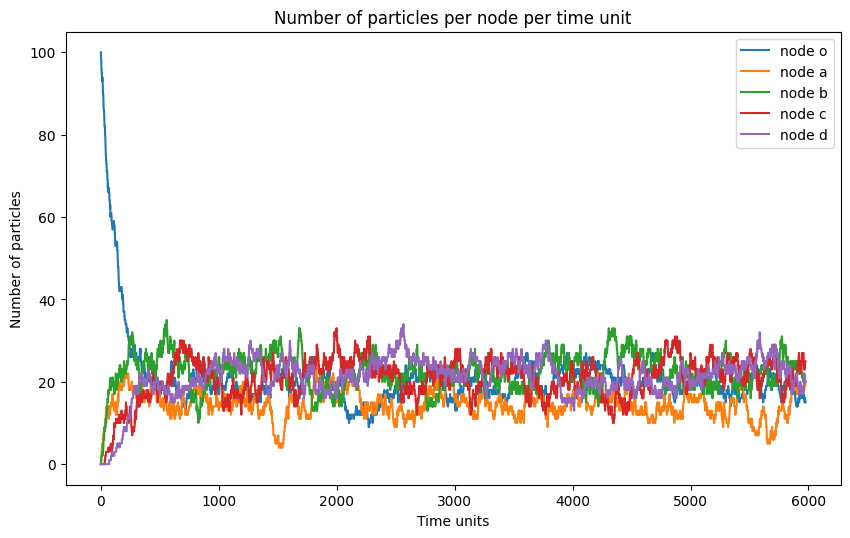

In [ ]:
end = i
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.subplot(111)
array = ['o', 'a', 'b', 'c', 'd']
for node in range(n_nodes):
    trajectory = pos[:end,node]
    ax.plot(trajectory, label='node {}'.format(array[node]))

ax.set_title("Number of particles per node per time unit")
ax.set_xlabel("Time units")
ax.set_ylabel("Number of particles")
    
ax.legend()

Compare the simulation result in the first point above with the stationary distribution of the continuous-time random walk followed by the single particles.

According to the central limit theorem, the estimated result of this simulation should be equal to the invariant probability vector $\bar{\pi}$ multiply by 100, because the invariant probability vector contains the probabilities that a single particle end up in each node.  

In [ ]:
print("Particles per node at final step: ", pos[end-1,:])
print("Average number of particles in every node: ", 100*pi_bar)

Particles per node at final step:  [15 20 20 25 20]
Average number of particles in every node:  [18.51851852 14.81481481 22.22222222 22.22222222 22.22222222]


# Problem 3
For this system, particles will enter the system at node o according to a Poisson process with rate λ= 1.  Each node will then pass along a particle according to a given rate, similar to whatyou did in Problem 2 with the “node perspective”. [...] Note that since node d does not have a node to send its particles to, when the Poisson clock ticks for this node you could simply decrease the number of particles in the node by one (if thereare any particles in the node).  Equivalently think of another node d′ connected to node d, such that at every tick of the Poisson clock of d, it sends a particle to node d′.

## Graph definition

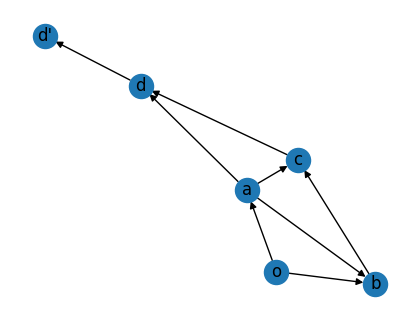

In [11]:
# draw graph
G = nx.DiGraph()
G.add_node('o')
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')
G.add_node("d'")
G.add_edges_from([('o', 'b'), ('o','a'), ('a','b'), ('a','c'), ('b', 'c'), ('a', 'd'), ('c', 'd'), ('d', "d'")])
pos = nx.spring_layout(G)
plt.figure(figsize=(4,3), dpi = 100)
nx.draw(G,pos, with_labels=True)

In [12]:
lambda_matrix = np.array([
          [0,   2/3, 1/3, 0,   0,   0],
          [0,   0,   1/4, 1/4, 2/4, 0],
          [0,   0,   0,   1,   0,   0],
          [0,   0,   0,   0,   1,   0],
          [0,   0,   0,   0,   0,   1],
          [0,   0,   0,   0,   0,   0]]) # added node d'

w = np.sum(lambda_matrix, axis=1)

# added self loop to overcome the problem "D is a singular matrix"
#for x, weight in enumerate(w):
#    if weight == 0:
#        lambda_matrix[x,x] = 1
#        w[x] = 1

#D = np.diag(w)
#P = np.linalg.inv(D) @ lambda_matrix
#P_cum = np.cumsum(P, axis=1)

n_nodes = len(G.nodes)

w_star = np.max(w)
Q = lambda_matrix/w_star 
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
Q_cum = np.cumsum(Q, axis=1)

In [13]:
print("Number of nodes: ", n_nodes)
print("\nVector w:\n", w)
print("\nMatrix D:\n", D)
print("\nMatrix P:\n", P)
print("\nMatrix P_cum:\n", P_cum)
print("\nMatrix Q:\n", Q)
print("\nMatrix Q_cum:\n", Q_cum)

Number of nodes:  6

Vector w:
 [1. 1. 1. 1. 1. 0.]

Matrix D:
 [[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]

Matrix P:
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.5        0.         0.5        0.        ]]

Matrix P_cum:
 [[0.         0.66666667 1.         1.         1.        ]
 [0.         0.         0.75       1.         1.        ]
 [0.5        0.5        0.5        1.         1.        ]
 [0.         0.         0.33333333 0.33333333 1.        ]
 [0.         0.5        0.5        1.         1.        ]]

Matrix Q:
 [[0.         0.66666667 0.33333333 0.         0.         0.        ]
 [0.         0.         0.25       0.25       0.5        0.        ]
 [0.         0.         0.         1.         0. 

## a. Proportional rate
The rate of the Poisson clock of each node is equal to the number of particles in it.
- Simulate the system for 60 time units and plot the evolution of the number of particles in each node over time.
- What is the largest input rate that the system can handle without blowing up?

In [19]:
def proportional_rate(input_rate):
  n_steps = 10000
  t_next = -np.log(np.random.rand())/w_star
  t_next_p = -np.log(np.random.rand())/input_rate

  pos = np.zeros((n_steps, n_nodes))
  pos[0,0] = 0
  transition_times = np.zeros(n_steps)
  transition_times_p = 0
  i = 0
  while transition_times[i-1] <= 60:
    # copy past state
    pos[i,:] = pos[i-1,:] 
    while transition_times_p <= transition_times[i-1]:
      pos[i,0] = pos[i,0] + 1
      transition_times_p = transition_times_p + t_next_p
      t_next_p = -np.log(np.random.rand())/input_rate

    
    if (pos[i, :-1] == np.zeros(5)).all():
      pos[i,0] = pos[i,0] + 1
      transition_times_p = transition_times_p + t_next_p
      t_next_p = -np.log(np.random.rand())/input_rate
      continue
    else:
      node = np.random.choice(5, p=pos[i,:-1]/np.sum(pos[i,:-1]))
    next_node = np.argwhere(Q_cum[node] > np.random.rand())[0] 
    transition_times[i] = transition_times[i-1] + t_next 
    t_next = -np.log(np.random.rand())/(w_star*np.sum(pos[i,:-1]))
    # node lose one particle
    pos[i,node] = pos[i,node]-1 
    # next node gain one particle
    pos[i,next_node] = pos[i,next_node]+1 
    i+=1
    
    #print("Step ", i)
    #print("Node {} lost 1 particle, node {} gained 1 particle".format(node, next_node))
    #print("Particles distribution: ", pos[i, :])
  return pos, transition_times, i

In [20]:
def plot_proportional_trajectories(pos, transition_times, input_rate):
  fig = plt.figure(figsize=(10,4), dpi=100)
  ax = plt.subplot(111)
  array = ['o', 'a', 'b', 'c', 'd']
  for node in range(n_nodes-1):
      trajectory = pos[:,node]
      ax.plot(transition_times, trajectory,'o-', label='node {}'.format(array[node]))
      
  ax.legend()
  ax.set_xlabel("Time units")
  ax.set_ylabel("Number of particles")
  ax.set_title("Input rate = {}".format(input_rate))

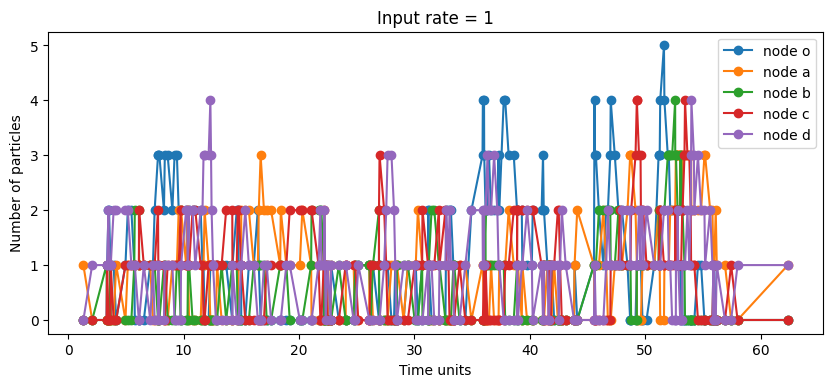

In [21]:
input_rate = 1
pos1, t1, end = proportional_rate(input_rate)
plot_proportional_trajectories(pos1[:end], t1[:end], input_rate)

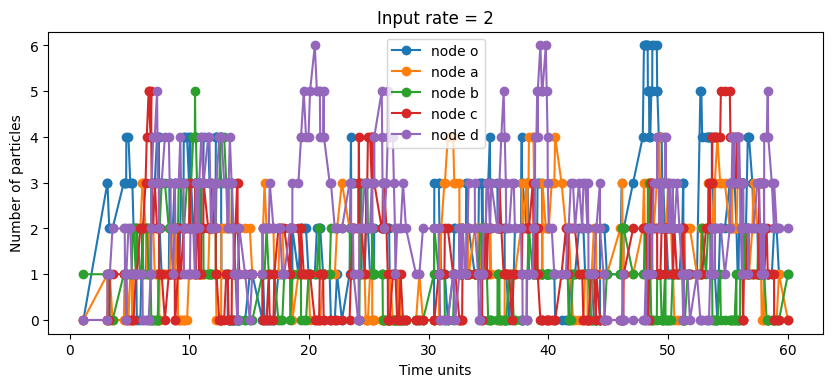

In [ ]:
input_rate = 2
pos2, t2, end = proportional_rate(input_rate)
plot_proportional_trajectories(pos2[:end], t2[:end], input_rate)

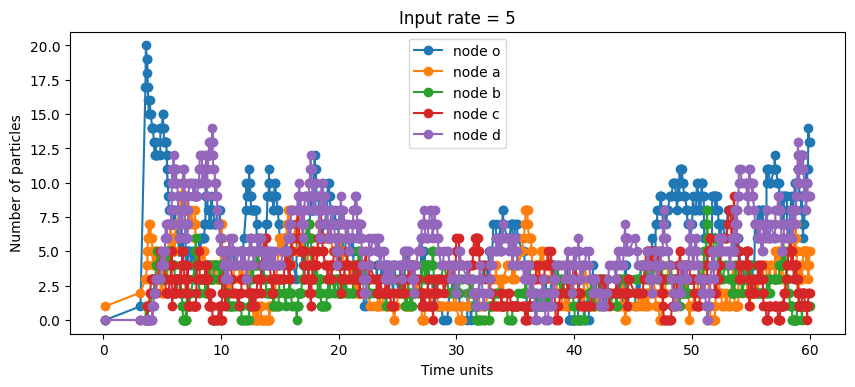

In [ ]:
input_rate = 5
pos3, t3, end = proportional_rate(input_rate)
plot_proportional_trajectories(pos3[:end], t3[:end], input_rate)

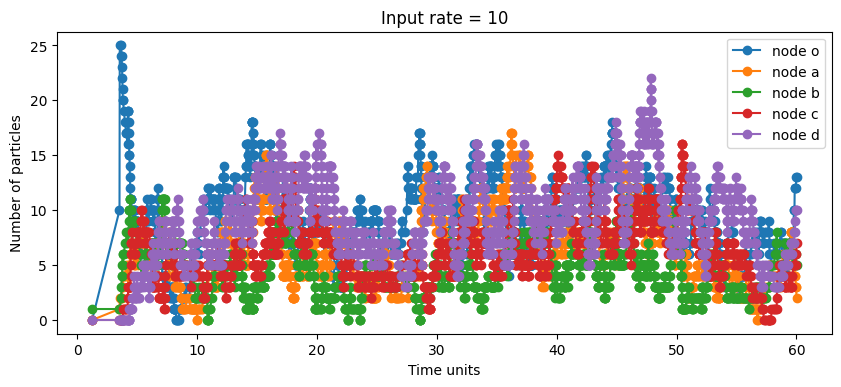

In [ ]:
input_rate = 10
pos3, t3, end = proportional_rate(input_rate)
plot_proportional_trajectories(pos3[:end], t3[:end], input_rate)


In this scenario we have two clock: one for the entrance of the particles with rate $\lambda$=1 and one global clock with rate proportional to the number of particles in the system. We keep an extra node d' for the particles exiting the system.

We simulate the system till we reach 60 time units. At every step we compare the cumulative transition time of the entrance clock and the one of the global clock: we let ticks the clock with the lower transition time.

For the simulation we set 4 different input rates: 1, 2, 5, 10. 

We can see the system does not blow up, in particular, particles do not accumulate in node 'o' and they move around the graph. This is due to the proportional rate of the global clock, the more particles are in the graph, the more the rate is higher. So each node is able to pass along its particles to other nodes.

## b. Fixed rate
The rate of the Poisson clock of each node is fixed, and equal to one.
- Simulate  the  system  for  60  time  units  and  plot  the  evolution  of  number  of  particles  in each node over time.
- What  is  the  largest  input  rate  that  the  system  can  handle  without  blowing  up?  Why  is this different from the other case?

In [ ]:
def fixed_rate(input_rate):
  n_steps = 10000
  t_next = -np.log(np.random.rand())/w_star
  t_next_p = -np.log(np.random.rand())/input_rate

  pos = np.zeros((n_steps, n_nodes))
  pos[0,0] = 0
  transition_times = np.zeros(n_steps)
  transition_times_p = 0
  i = 0
  while transition_times[i-1] <= 60:
    # copy past state
    pos[i,:] = pos[i-1,:] 
    while transition_times_p <= transition_times[i-1]:
      pos[i,0] = pos[i,0] + 1
      transition_times_p = transition_times_p + t_next_p
      t_next_p = -np.log(np.random.rand())/input_rate

    
    admissibles_nodes = np.argwhere(pos[i,:-1]!=0)
    #print(admissibles_nodes)
    if (admissibles_nodes.size==0):
      pos[i,0] = pos[i,0] + 1
      transition_times_p = transition_times_p + t_next_p
      t_next_p = -np.log(np.random.rand())/input_rate
      continue
    else:
      node = np.random.choice(admissibles_nodes.flatten())
    next_node = np.argwhere(Q_cum[node] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next 
    t_next = -np.log(np.random.rand())/(w_star)
    # node lose one particle
    pos[i,node] = pos[i,node]-1 
    # next node gain one particle
    pos[i,next_node] = pos[i,next_node]+1 
    i+=1
    
    #print("Step ", i)
    #print("Node {} lost 1 particle, node {} gained 1 particle".format(node, next_node))
    #print("Particles distribution: ", pos[i, :])
  return pos, transition_times, i

In [ ]:
def plot_fixed_trajectories(pos, transition_times, input_rate):
  fig = plt.figure(figsize=(10,6), dpi=100)
  ax = plt.subplot(111)
  array = ['o', 'a', 'b', 'c', 'd']
  for node in range(n_nodes-1):
      trajectory = pos[:,node]
      ax.plot(transition_times, trajectory, 'o-', label='node {}'.format(array[node]))
      
  ax.legend()
  ax.set_xlabel("Time units")
  ax.set_ylabel("Number of particles")
  ax.set_title("Input rate = {}".format(input_rate))

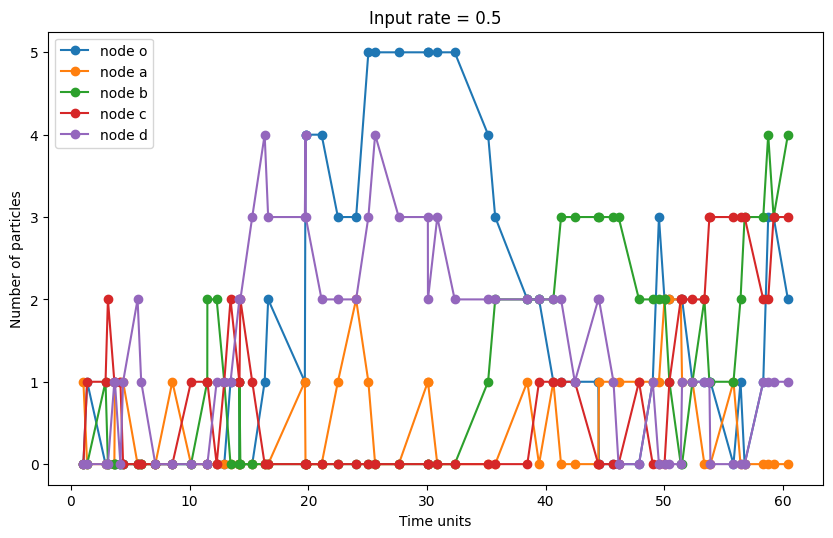

In [ ]:
input_rate = 0.5
pos1, t1, end = fixed_rate(input_rate)
plot_fixed_trajectories(pos1[:end], t1[:end], input_rate)

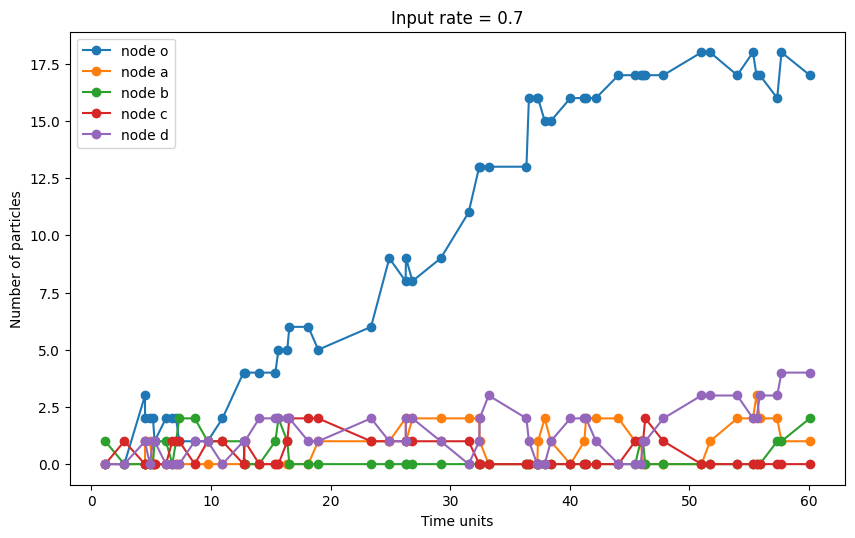

In [ ]:
input_rate = 0.7
pos2, t2, end = fixed_rate(input_rate)
plot_fixed_trajectories(pos2[:end],t2[:end],input_rate)

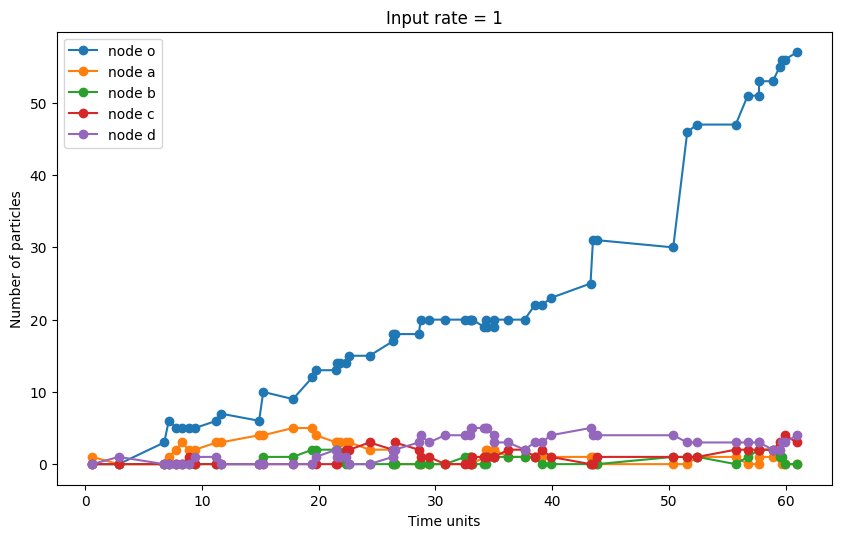

In [ ]:
input_rate = 1
pos3, t3, end = fixed_rate(input_rate)
plot_fixed_trajectories(pos3[:end],t3[:end],input_rate)

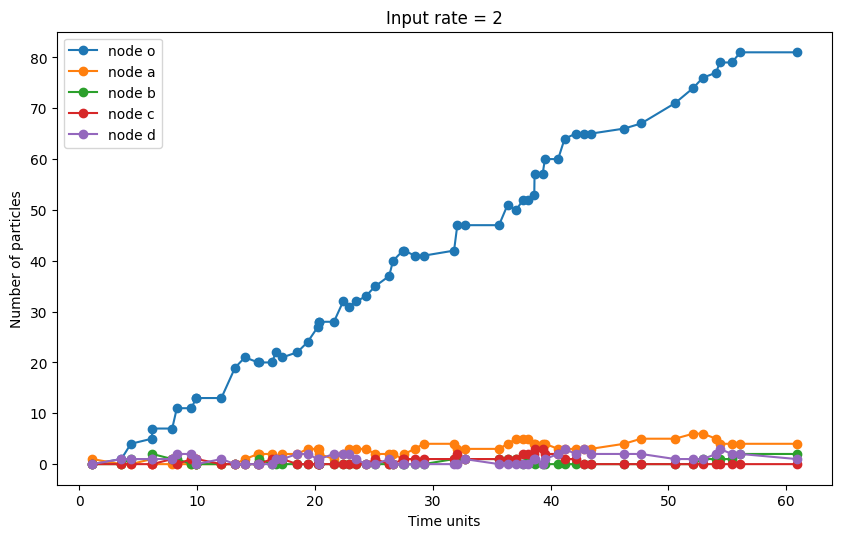

In [ ]:
input_rate = 2
pos4,t4, end = fixed_rate(input_rate)
plot_fixed_trajectories(pos4[:end] ,t4[:end] ,input_rate)

The difference between this simulation and the past one is the rate of the globl clock: in this case it is fixed and equals to 1 ($w_{star}$: the value of the maximum value from the vector $w$)

We simulate the  rate case with 4 different input rates: 0.5, 0.7, 1, 2. 

In this scenario we can clearly see that particles accumulate in node 'o' causing the blow-up. From the plot we can identify the crucial input rate: 0.7.